# 特徴点のマッチング

## 目的
このチュートリアルでは
* 二枚の画像の特徴点のマッチングについて学ぶ．
* OpenCVが提供する総当たりマッチングとFLANNを使ったマッチングの使い方を学ぶ．


## 総当たりマッチング(BFMatcher)の基礎
総当たりマッチング(Brute-Force matcher、力任せ手法)は単純である．最初の画像にある一つの特徴点の特徴量記述子を計算し，二枚目の画像中の全特徴点の特徴量と何らかの距離計算に基づいてマッチングをする．最も距離が小さい特徴点が対応する特徴点がマッチング結果として返される．

総当りマッチングではまず初めに [cv2.BFMatcher({, normType{, crossCheck}})](http://docs.opencv.org/3.2.0/d3/da1/classcv_1_1BFMatcher.html) を使ってBFMatcher型のオブジェクトを生成する．この関数は2つのオプショナルパラメータがあり、1つ目のパラメータ `normType` はマッチングコストの計算に使われる距離計算方法を指定する。デフォルトは `cv2.NORM_L2` で、SIFTやSURFといった特徴量記述子に向いている (`cv2.NORM_L1` も同様)．ORB, BRIEF, BRISKのような二値ベクトル(特徴ベクトルの各要素が二値の特徴量記述子)については `cv2.NORM_HAMMING` を指定し，特徴ベクトル間のハミング距離を使うべきである．もしORBに対して `VTA_K == 3 or 4` と指定するのであれば， `cv2.NORM_HAMMING2` を使うべきである．

2つ目のパラメータはブール型変数の `crossCheck` で，デフォルト値はFalseに設定されている。Trueに設定すると，マッチングのクロスチェックが行われ，クロスチェックが確立されたマッチング結果のみが返される．ここでクロスチェックとは，特徴点群Aの中のi番目の特徴ベクトルの最大マッチング結果が特徴点群Bの中のj番目の特徴ベクトルとなった時に，特徴点群Bの中のj番目の特徴ベクトルの最大マッチング結果が特徴点群Aの中のi番目の特徴ベクトルとなるかどうかを確認することを意味する．２つの特徴点群の特徴点が互いにベストマッチとなるかの確認である．この確認により安定した結果が得られ、D. LoweのSIFT論文で提案された「割合試験」に対する良い代替案である。

BFMatcher型オブジェクトを一度作れば，それ以降重要なのは `BFMatcher.match()`関数と [BFMatcher.knnMatch()](https://docs.opencv.org/3.2.0/db/d39/classcv_1_1DescriptorMatcher.html#a378f35c9b1a5dfa4022839a45cdf0e89)関数である．前者は各点に対して最も良いマッチング・スコアを持つ対応点だけを返すが，後者は上位 k 個の特徴点を返すので、マッチングした後に追加処理をする時に便利かもしれない．

検出した特徴点の描画に[cv2.drawKeypoints()](https://docs.opencv.org/3.2.0/d4/d5d/group__features2d__draw.html#gab958f8900dd10f14316521c149a60433)関数を使ったように，マッチングの結果を描画するには [cv2.drawMatches()](http://docs.opencv.org/3.0-beta/modules/features2d/doc/drawing_function_of_keypoints_and_matches.html?highlight=cv2.drawmatch#cv2.drawMatches) を使う．この関数を使うと，マッチングを行った2枚の画像を横方向に連結し，対応点を線でつないだ可視化を行う． `cv2.drawMatchesKnn` という関数を使うと，上位$k$個の対応点を描画する．例えば `k=2` と設定すれば，各特徴点に対して2本のマッチング結果を示す直線を描画する．特定の検出点だけを描画するには`mask`を指定する必要がある．

それでは，SURFとORBそれぞれの例を示そう(それぞれ違う距離計算をする)．



### ORBを使った総当りマッチング
ここでは単純な例を使って2枚の画像の特徴点のマッチングの方法を学ぶ．今回のケースではクエリ画像と学習画像がそれぞれ1枚ずつあり，特徴点のマッチングによって学習画像の中からクエリ画像を見つける(画像はOpenCVの[/samples/c/box.png](http://lang.sist.chukyo-u.ac.jp/Classes/OpenCV/py_tutorials/py_feature2d/py_matcher/box.png) と[/samples/c/box_in_scene.png](http://lang.sist.chukyo-u.ac.jp/Classes/OpenCV/py_tutorials/py_feature2d/py_matcher/box_in_scene.png) を使う)．

特徴点のマッチングにはORBを使う．早速画像を取り込み特徴記述子の計算などを始めよう．

In [7]:
%matplotlib inline
import numpy as np
import cv2
import matplotlib.pyplot as plt

img1 = cv2.imread('box.png',0)          # queryImage
img2 = cv2.imread('box_in_scene.png',0) # trainImage

# Initiate ORB detector
orb = cv2.ORB_create()

# find the keypoints and descriptors with ORB
kp1, des1 = orb.detectAndCompute(img1,None)
kp2, des2 = orb.detectAndCompute(img2,None)

print("len(kp1)=%d, len(kp2)=%d"%(len(kp1),len(kp2)))


len(kp1)=454, len(kp2)=500


次にBFMatcher型のオブジェクトを作成する．その際，距離測定を(ORBを使うので) `cv2.NORM_HAMMING` とし，`crossCheck` を `True` に設定する．そして， `Matcher.match()`関数を使い2画像間の最も良いマッチング結果を取得する．マッチング結果を昇順にソートし、最も良いマッチング結果(距離が低いもの)から順番に並ぶようにする．ここでは見やすさのために，マッチング結果のうち上位10個の対応点のみ描画するが、10にこだわらず好きなだけ描画しても構わない。

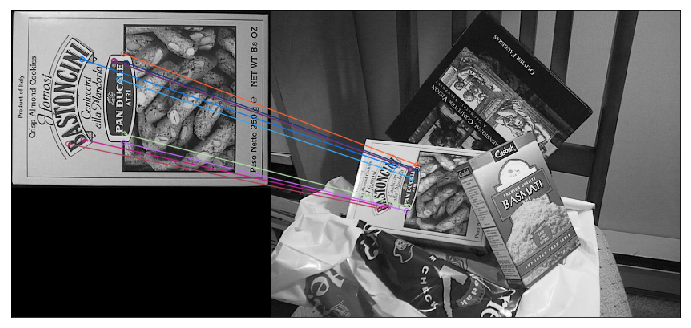

In [12]:
# BFMatcherオブジェクトを作る
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

# 特徴記述子のマッチング
matches = bf.match(des1,des2)

# 距離でソートする
matches = sorted(matches, key = lambda x:x.distance)

# 最初の（上位）10個の対応点を描画
img3 = cv2.drawMatches(img1,kp1,img2,kp2,matches[:10], None,flags=2)
 
plt.figure(figsize=(12,6))
plt.xticks([]), plt.yticks([]) 
plt.imshow(img3)

## このMatcher型オブジェクトとは何か?
上のコードで `matches = bf.match(des1,des2)` では、DMatch型オブジェクトのリストが結果がとして返される．このDMatch型オブジェクトは以下のような属性を持っている:

* `DMatch.distance` - 特徴量記述子間の距離．低いほど良い．
* `DMatch.trainIdx` - 学習記述子(参照データ)中の記述子のインデックス．
* `DMatch.queryIdx` - クエリ記述子(検索データ)中の記述子のインデックス．
* `DMatch.imgIdx` - 学習画像のインデックス．

## SIFTを使った総当りマッチングと割合試験(ratio test)
今度は上位$k$個のマッチング結果を得るために `BFMatcher.knnMatch()` を使う。この例ではk=2とし，D. Loweが論文中で説明した割合試験を行う:

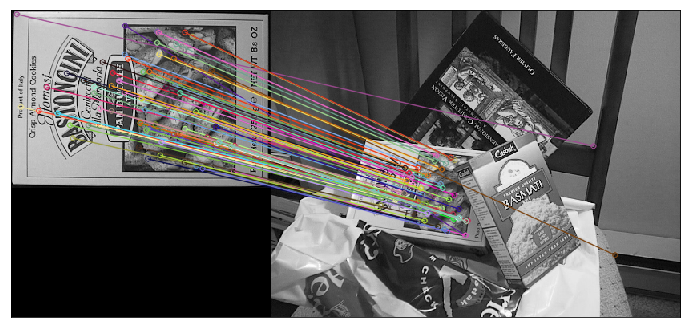

In [14]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

img1 = cv2.imread('box.png',0)          # queryImage
img2 = cv2.imread('box_in_scene.png',0) # trainImage

# SIFT特徴検出器を始める
sift = cv2.xfeatures2d.SIFT_create()

# SIFTを用いてキーポイントと特徴記述子を求める
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)

# デフォルトのパラメタを使ったBFMatcher
bf = cv2.BFMatcher()
matches = bf.knnMatch(des1,des2, k=2)

# 割合試験を適用
good = []
for m,n in matches:
    if m.distance < 0.75*n.distance:
        good.append([m])

# cv2.drawMatchesKnn はmatchesとしてリストを期待
img3 = cv2.drawMatchesKnn(img1,kp1,img2,kp2,good, None,flags=2)

plt.figure(figsize=(12,6))
plt.xticks([]), plt.yticks([]) 
plt.imshow(img3)

## FLANNベースのマッチング

FLANNとはFast Library for Approximate Nearest Neighbors(近似的再近傍法のための高速ライブラリ)の略で，高速な近似的最近傍探索を行うためのライブラリであり、大規模データや高次元データに対する高速な最近傍探索のために最適化されたアルゴリズムを提供している．大規模データに対してBFMatcherよりも高速に動作する．上記のSIFTを使ったマッチングにFLANNベースのマッチングを導入してみよう．

FLANNベースのマッチングのために，使用する検索アルゴリズム及び関連するパラメータを指定する2つの辞書型オブジェクトを引数として指定する必要がある．一つ目の辞書はIndexParams(インデックス・パラメータ)である．各種アルゴリズムの指定すべき情報はFLANNのドキュメントで説明されている．簡単に言えば、SIFTやSURFのようなアルゴリズムに対しては以下のような情報を与えればよい:

**注意**: OpenCVの元チュートリアルには上のようにあるのだが、以下に見るようにFLANNは動かない状況である。理由は不明

In [15]:
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)

NameError: name 'FLANN_INDEX_KDTREE' is not defined

一方、ORBを使う場合は，以下のような情報を与えればよい．コメント・アウトされた値はドキュメントで推奨されていた値であるが，状況次第では要求される結果に至らないことがある。それ以外の値はうまくいく:

**注意**: 現状では動かない

In [ ]:
index_params= dict(algorithm = FLANN_INDEX_LSH,
                   table_number = 6, # 12
                   key_size = 12,     # 20
                   multi_probe_level = 1) #2


2つ目の辞書はSearchParams(探索パラメータ)である．インデックス中の木構造を再帰的にたどる回数を指定する．高い値を設定すれば精度は良くなるが，時間も多くかかる．値を変更するのであれば search_params = dict(checks=100) と指定する．

それではコードを見てみよう

**注意**: flann.knnMatchでエラーになり解消不能

In [ ]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

img1 = cv2.imread('box.png',0)          # queryImage
img2 = cv2.imread('box_in_scene.png',0) # trainImage

# SIFT検出器を始める
sift = cv2.xfeatures2d.SIFT_create()

# SIFTでキーポイントと特徴記述子を求める
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)

# FLANNのパラメータ
FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)   # or pass empty dictionary

flann = cv2.FlannBasedMatcher(index_params,search_params)

matches = flann.knnMatch(des1,des2,k=2)

# 良い対応点だけを描画するため、マスクを作る
matchesMask = [[0,0] for i in xrange(len(matches))]

# Lowe論文に従う割合試験
for i,(m,n) in enumerate(matches):
    if m.distance < 0.7*n.distance:
        matchesMask[i]=[1,0]

draw_params = dict(matchColor = (0,255,0),
                   singlePointColor = (255,0,0),
                   matchesMask = matchesMask,
                   flags = 0)

img3 = cv2.drawMatchesKnn(img1,kp1,img2,kp2,matches,None,**draw_params)

plt.imshow(img3,),plt.show()

この結果、いかが得られるはずなのだが。。。
![](http://lang.sist.chukyo-u.ac.jp/Classes/OpenCV/_images/matcher_flann.jpg)

## 補足資料

OpenCV3 python calls to FlannBasedMatcher::knnMatch fail with error #5667: FLANNでknnMatchを利用した時にエラーになることがある(Anaconda Pythonではそう2017年1月)。その時はOpenCV 2の環境にしたほうがよいようである。OpenCV 3とPython 3の組み合わせで動かす場合は、FLANNではなく総当たり法（Brute-Force）を使用する(OpenCV3.1ではパッチが入ったそうだが、確認できない)
